In [1]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Network

In [3]:
class ResNetLike(nn.Module):
  def __init__(self, depth_n):
    super(ResNetLike, self).__init__()
    self.start = nn.Sequential(OrderedDict([('conv0', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)),
                ('relu0', nn.LeakyReLU()),
                ('bn0', nn.BatchNorm2d(16))]))
    self.i_list = [0, 1, 2]
    self.depth_n = depth_n
    self.block1_list = nn.ModuleList([])
    self.block2_list = nn.ModuleList([])
    self.identity_scale_list = nn.ModuleList([])
    self.add_channels_list = nn.ModuleList([])
    for i in self.i_list:
        for n in range(2 * self.depth_n - 1):
            i_channels = 16 * (2 ** i)
            b1 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels),
                  nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(i_channels)]
            self.block1_list.append(nn.Sequential(*b1))
#         if i != self.i_list[-1]:
        i_channels = 16 * (2 ** i)
        last_channels = 16 * (2 ** (i+1))
        b2 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(i_channels),
              nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(i_channels)]
        self.block2_list.append(nn.Sequential(*b2))
        self.identity_scale_list.append(nn.AvgPool2d(2, stride=2))
        b3 = [nn.Conv2d(in_channels=i_channels, out_channels=last_channels, kernel_size=1, stride=1, padding=0),
                  nn.LeakyReLU(),
                  nn.BatchNorm2d(last_channels)]
        self.add_channels_list.append(nn.Sequential(*b3))
#         else:
#             i_channels = 16 * (2 ** i)
#             b2 = [nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
#                   nn.LeakyReLU(),
#                   nn.BatchNorm2d(i_channels),
#                   nn.Conv2d(in_channels=i_channels, out_channels=i_channels, kernel_size=3, stride=1, padding=1),
#                   nn.LeakyReLU(),
#                   nn.BatchNorm2d(last_channels)]
#             self.block2_list.append(nn.Sequential(*b2))
#     self.end = nn.Sequential(*[nn.Linear(16 * (2 ** 2) * 8 * 8, 10), nn.Softmax(dim=1)])
    self.end = nn.Linear(16 * (2 ** 3) * 4 * 4, 10)
                                           

  def forward(self, x):
    y = self.start(x)
    block1_counter = 0
    for i in self.i_list:
        for n in range(2 * self.depth_n - 1):
            identity = y
            y = self.block1_list[block1_counter](y)
            y += identity
            block1_counter += 1
#         if i != self.i_list[-1]:
        identity = y
        y = self.block2_list[i](y)
        y += self.identity_scale_list[i](identity)
        y = self.add_channels_list[i](y)
#         else:
#             identity = y
#             y = self.block2_list[i](y)
#             y += identity
    return self.end(y.reshape([y.shape[0],-1]))
    

# Dataset

In [4]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

In [7]:
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32]) torch.Size([64])


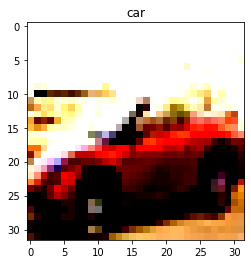

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


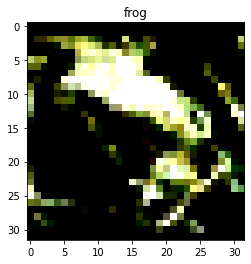

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


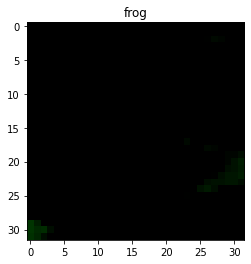

In [9]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
plt.imshow(x[0].permute(1, 2, 0))
plt.title(classes[y[0].item()])
plt.show()
plt.imshow(x[1].permute(1, 2, 0))
plt.title(classes[y[1].item()])
plt.show()
plt.imshow(x[2].permute(1, 2, 0))
plt.title(classes[y[2].item()])
plt.show()

# Train one iteration

In [10]:
#test train batch size
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

In [11]:
resnet_model = ResNetLike(depth_n=1)
resnet_model.cuda()
resnet_optim = optim.Adam(resnet_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
probs = nn.Softmax(dim=1)

batch = next(iter(train_loader))
x, y = batch
x, y = x.cuda(), y.cuda()
output = resnet_model(x)
loss = criterion(output, y)
loss.backward()
resnet_optim.step()

In [12]:
#sums to 1 due to softmax
softmax_output = probs(output)
print(softmax_output[0])
print(sum(softmax_output[0]))

tensor([0.0467, 0.0775, 0.0905, 0.0822, 0.1185, 0.1624, 0.0545, 0.1179, 0.0414,
        0.2084], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
torch.argmax(softmax_output, dim=1)

tensor([9, 6, 7, 4, 4, 7, 1, 9, 5, 9, 1, 1, 4, 3, 7, 4, 2, 0, 6, 1, 4, 5, 3, 6,
        4, 6, 8, 9, 9, 1, 1, 9, 5, 6, 0, 9, 1, 7, 1, 5, 1, 4, 4, 5, 1, 5, 8, 7,
        5, 5, 9, 6, 6, 5, 6, 5, 9, 9, 5, 5, 4, 5, 3, 1], device='cuda:0')

In [14]:
torch.sum(torch.argmax(softmax_output, dim=1) == y) / len(y)

tensor(0.0938, device='cuda:0')

# Train

In [15]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  probs = nn.Softmax(dim=1)
  model.train()
  losses = []
  batch_total = len(train_loader)

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
        
      softmax_output = probs(output)
      
      yhat = torch.argmax(softmax_output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())


      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)

        if use_test:
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_y)

          test_yhat = torch.argmax(test_output, dim=1)
          test_acc = float(torch.sum(test_yhat == test_y)) / float(len(test_y))
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%} Test loss: {test_loss:.6f} Test acc: {test_acc:.2%}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')

  return losses

In [16]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  criterion = nn.CrossEntropyLoss()
  probs = nn.Softmax(dim=1)
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      softmax_output = probs(output)
      yhat = torch.argmax(softmax_output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

## Define the model and run the training

In [25]:
resnet_model = ResNetLike(depth_n=3)
summary(resnet_model, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         LeakyReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
         LeakyReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,320
         LeakyReLU-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,320
        LeakyReLU-11           [-1, 16, 32, 32]               0
      BatchNorm2d-12           [-1, 16, 32, 32]              32
           Conv2d-13           [-1, 16, 32, 32]           2,320
        LeakyReLU-14           [-1, 16,

In [26]:
resnet_model = resnet_model.cuda()
resnet_optim = optim.Adam(resnet_model.parameters(), lr=1e-3)
resnet_losses = train(resnet_model, resnet_optim, (train_loader, test_loader), max_epochs=20)

Epoch: 19/20 Step: 750/782 Loss: 514.700806 Acc: 18.94% Test loss: 9853231.000000 Test acc: 17.19%%%

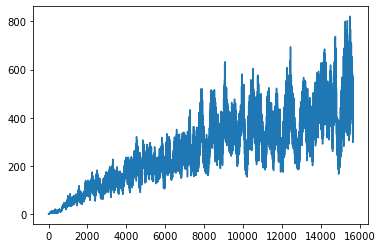

In [27]:
plt.plot(resnet_losses)

### Result Training:
n=1: Loss: 527.882629 Acc: 20.09% Test loss: 597.749878 Test acc: 23.44% <br>
n=2: Loss: 494.813629 Acc: 18.13% Test loss: 512.728088 Test acc: 15.62% <br>
n=3: Loss: 514.700806 Acc: 18.94% Test loss: 9853231.000000 Test acc: 17.19%<br>

## Run the Testing:

In [29]:
validate(resnet_model, test_loader)

Validation complete! Validation loss: 454.013904, Validation accuracy: 20.65%


(454.01390376971784, 0.2065)

### Result Testing:
n=1: <br>
n=2: <br>
n=3: Validation loss: 454.013904, Validation accuracy: 20.65% <br>

# Save Checkpoint

In [79]:
checkpoint = {
    'model_state_dict': resnet_model.state_dict(),
    'optimizer_state_dict': resnet_optim.state_dict(),
    'depth_n' = resnet_model.depth_n
    'epoch': 10,
    'losses': resnet_losses
}

In [82]:
filename = 'resnet_model:10.pth'
# checkpoint_path = os.path.join(root_path, 'My Drive', 'MLVideos', filename)

with open(filename, 'wb') as f:
  pk.dump(checkpoint, f)

# Load Checkpoint

In [83]:
with open(filename, 'rb') as f:
  checkpoint_ = pk.load(f)

In [88]:
resnet_model = ResNetLike(depth_n=checkpoint_['depth_n'])
resnet_model = resnet_model.cuda()
resnet_model.load_state_dict(checkpoint_['model_state_dict'])

<All keys matched successfully>

In [28]:
validate(resnet_model, test_loader)

Validation complete! Validation loss: 455.793573, Validation accuracy: 20.31%


(455.7935732701782, 0.2031)